# Bank Market Outcome Analysis
From-Scratch cleaning and building a predictive model on bank campaign data.

### Features:
- "Id": Id number of clients (numeric)

- "age": age (numeric)

- "job": type of work (categorical: "admin.", "unknown", "unemployed", "management", "housemaid", "entrepreneur", "student", "blue-collar", "self-employed", "retired", "technician", "services")

- "marital": marital status (categorical: "married", "divorced", "single")

- "education": education level (categorical: "unknown", "secondary", "primary", "tertiary")

- "default": if left to pay its obligation (categorical: "yes", "no")

- "balance": annual balance in euros (numeric)

- "housing": Do you have a mortgage credit? (categorical: "yes", "no")

- "loan": Do you have consumer loans? (categorical: "yes", "no")

- "contact": medium that person was contacted (categorical: "unknown", "telephone", "cellular")

- "day": the last day that person was contacted (numeric)

- "month": the last month that person was contacted (categorical: "jan", "feb", "mar", ..., "nov", "dec")

- "duration": length of time (in seconds) of the last contact (numeric)

- "campaign": total number of times the person was contacted during the campaign (numeric)

- "pdays": number of days elapsed after the person was being contacted before the actual campaign (numeric. -1 indicates that they were not contacted previously)

- "previous": number of times that the person had been contacted before this campaign (numeric)

- "poutcome": result of the last marketing campaign (categorical: "unknown", "other", "failure", "success")

- "y": Did the client subscribe to the product (term deposit)? (categorical: "yes", "no")

In [142]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_tree, plot_importance
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, log_loss

In [224]:
bank_data = pd.read_csv('dataset.csv')

print(f"Missing:\n{bank_data.isnull().sum()}")  #Get null counts in each row
print(f"Total number of Rows: {len(bank_data)}")  #total rows

Missing:
Id            0
age          12
job           1
marital       0
education     0
default       0
balance       3
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
y             0
dtype: int64
Total number of Rows: 45211


# Data Cleaning
Since there are so many rows, I am going to go ahead and drop all of the rows with missing values. (like a fraction)

In [225]:
bank_data = bank_data.dropna()

#remove duplicates and ID column
bank_data.drop_duplicates(inplace=True)
bank_data.drop(columns=['Id'], inplace=True)

#look for qualitative data's unique values
qual = bank_data.select_dtypes(include=['object'])
for col in qual.columns:
    print(f"{col}: {bank_data[col].unique()}")
    
print(bank_data.columns)
    

job: ['blue-collar' 'unknown' 'management' 'admin.' 'technician' 'services'
 'retired' 'entrepreneur' 'self-employed' 'unemployed' 'housemaid'
 'student']
marital: ['married' 'single' 'divorced']
education: ['unknown' 'tertiary' 'secondary' 'primary']
default: ['no' 'yes']
housing: ['yes' 'no']
loan: ['no' 'yes']
contact: ['unknown' 'cellular' 'telephone']
month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
poutcome: ['unknown' 'failure' 'other' 'success']
y: ['no' 'yes']
Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')


In [123]:
le = LabelEncoder()

#encode non-numerical columns
label_columns = ['default', 'housing','month', 'loan', 'y']
for col in label_columns:
    bank_data[col] = le.fit_transform(bank_data[col])
    
categorical_columns = ['job', 'marital', 'education', 'contact', 'poutcome']
bank_data = pd.get_dummies(bank_data, columns=categorical_columns)
    

#fill missing values
bank_data['age'].fillna(bank_data['age'].median(), inplace=True)
bank_data['balance'].fillna(bank_data['balance'].median(), inplace=True)

5 most positively correlated pairs:

pdays               poutcome_failure      0.701040
poutcome_failure    pdays                 0.701040
job_management      education_tertiary    0.598929
education_tertiary  job_management        0.598929
pdays               previous              0.454804
dtype: float64
5 most negatively correlated pairs:

marital_single    marital_married    -0.772316
contact_cellular  contact_unknown    -0.862313
contact_unknown   contact_cellular   -0.862313
pdays             poutcome_unknown   -0.869955
poutcome_unknown  pdays              -0.869955
dtype: float64


<Axes: >

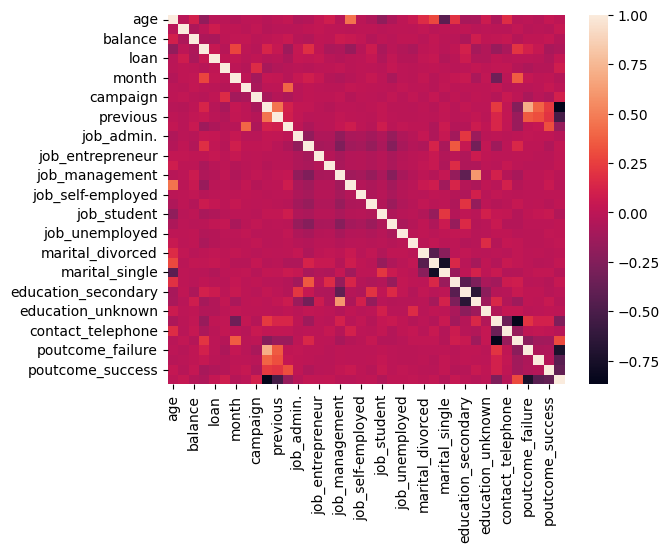

In [124]:
#display correlation heatmap
corr = bank_data.corr(numeric_only=True)

corr_stack = corr.stack() #corr dataframe
unique_corr_pairs = corr_stack[corr_stack.index.get_level_values(0) != corr_stack.index.get_level_values(1)]
sorted_pairs = unique_corr_pairs.sort_values(kind="quicksort", ascending=False)

print("5 most positively correlated pairs:\n")
print(sorted_pairs.head(5))

print("5 most negatively correlated pairs:\n")
print(sorted_pairs.tail(5))

sns.heatmap(corr)

In [125]:
bank_data.describe()

,age,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,y
count,45197.000000,45197.000000,45197.000000,45197.000000,45197.000000,45197.000000,45197.000000,45197.000000,45197.000000,45197.000000,45197.000000,45197.000000
mean,40.933204,0.018010,1362.608027,0.555723,0.160210,15.809766,5.522247,258.147974,2.764387,40.210589,0.580503,0.117021
std,10.623076,0.132989,3045.162034,0.496891,0.366805,8.321591,3.007060,257.444942,3.098345,100.141627,2.303775,0.321449
min,-1.000000,0.000000,-8019.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,0.000000,72.000000,0.000000,0.000000,8.000000,3.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,0.000000,449.000000,1.000000,0.000000,16.000000,6.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,0.000000,1428.000000,1.000000,0.000000,21.000000,8.000000,319.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,1.000000,102127.000000,1.000000,1.000000,31.000000,11.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


In [153]:
X = bank_data.drop(columns=['y'])
y = bank_data['y']

#create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#create a dmatrix from the data
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X.columns.tolist())
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X.columns.tolist())



In [216]:
#Parameters
n_folds = 5
n_rounds = 150 #n_estimators
param = {
    'learning_rate': 0.08,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'max_depth': 5,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}
kf = KFold(n_splits=n_folds, shuffle=True, random_state=45)
xgb_bank = xgb.train(param, dtrain, n_rounds, evals=[(dtest, 'test')], early_stopping_rounds=10, verbose_eval=False) #train the model
dump_list = xgb_bank.get_dump()

In [217]:
threshold = 0.5
y_pred = xgb_bank.predict(dtest)
y_pred = (y_pred >= threshold).astype(int) #convert the prediction to binary using the threshold

#Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

#Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

#Precision, Recall, f1-Score
class_report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{class_report}")

#ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC Score: {roc_auc}")

#logloss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.905641592920354
Confusion Matrix:
[[7693  267]
 [ 586  494]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7960
           1       0.65      0.46      0.54      1080

    accuracy                           0.91      9040
   macro avg       0.79      0.71      0.74      9040
weighted avg       0.90      0.91      0.90      9040

ROC-AUC Score: 0.7119323469197841
Log Loss: 3.401021719127979


The parameters can be messed around with to tune the model and make sure that it doesn't overfit/underfit.
The booster can be visualized so that you can see what's going on inside the model.

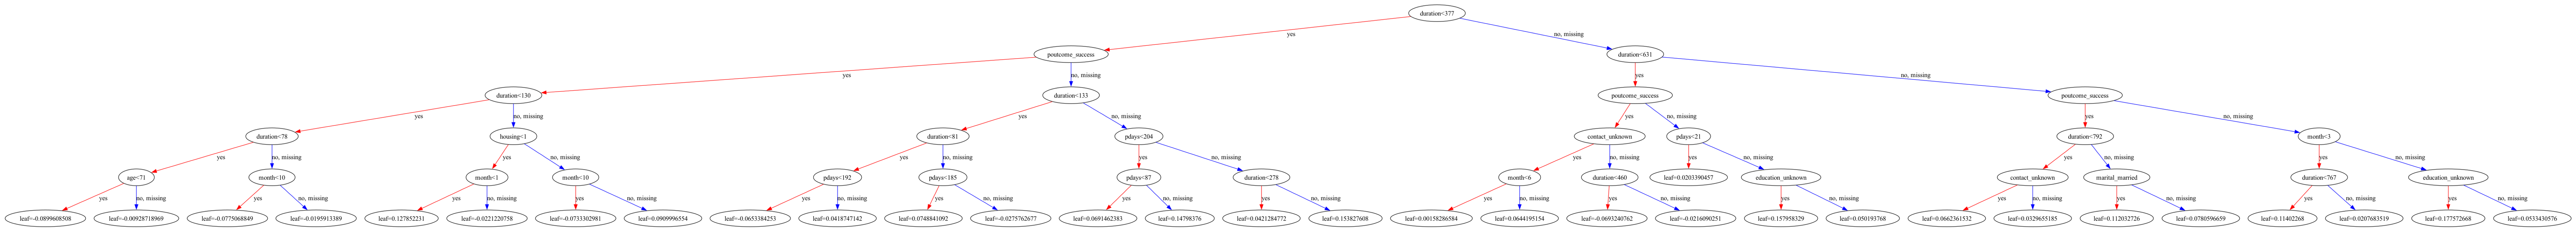

In [218]:
#Visualize a tree in the classifier (the fifth tree)
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(xgb_bank, ax=ax, num_trees=5)
fig.set_size_inches(100, 25)
fig.savefig('Model_Tree_5.png')
plt.show()

Here, an importance diagram is generated to show the importance of each feature in the final decision.

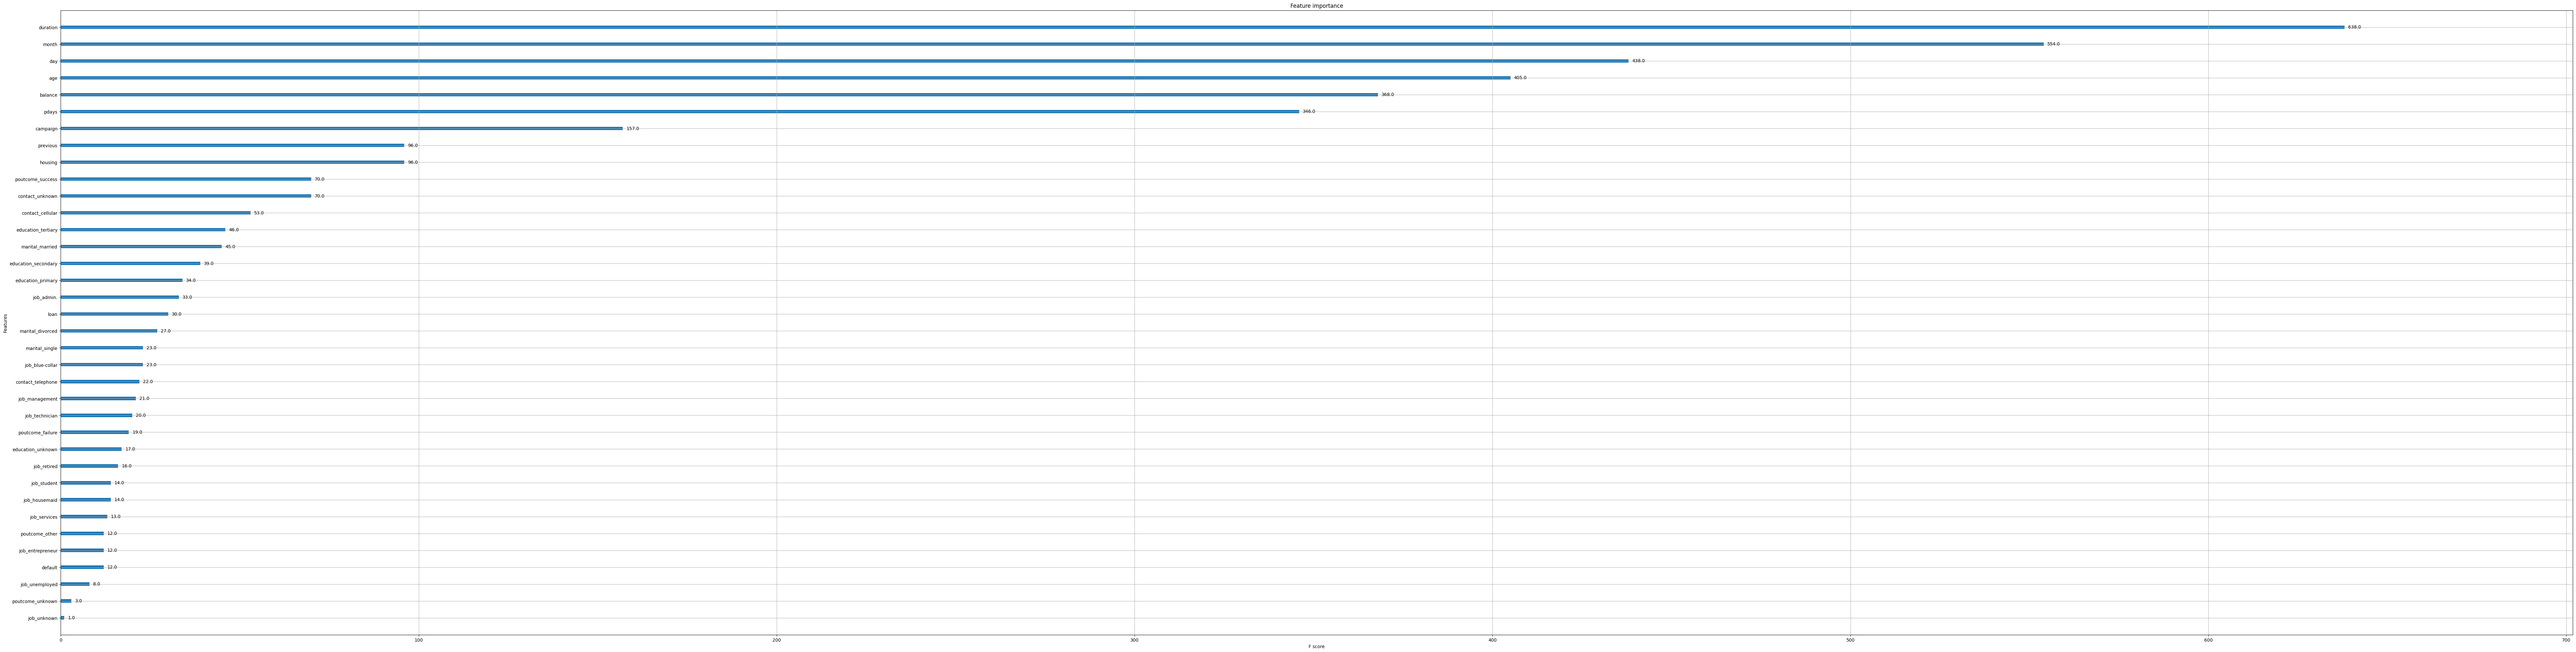

In [221]:
#importance diagram
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_importance(xgb_bank, ax=ax, show_values=True)
fig.set_size_inches(100, 25)
fig.savefig('Importance_Diagram.png')
plt.show()

# Model Inference
Now that I have a model for predicting a bank's campaign success, I can make it useful by providing an interface for inference.

In [222]:
xgb_bank.save_model(fname='campaign.model')

/opt/homebrew/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [14:53:18] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
